# Mixture Density Network

This notebook trains a simple gaussian mixture density network from basic statistics of the predictive distributions coming from the component models.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import data
import utils as u
import os
import losses

from functools import partial
from jrun import jin
from keras.layers import (Activation, Dense, Dropout, Embedding, Flatten, Merge, Reshape)
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import keras.backend as K

Using Theano backend.


## Setup notebook parameters

In [55]:
EXP_NAME = jin("exp", "mdn/seasons-14-to-5")
COMPONENTS = jin("components", ["kcde", "kde", "sarima"])
WEEK_NUMBER = jin("week", 4)
TEST_SPLIT_THRESH = jin("splitweek", 201143)

## Load data

In [56]:
class Component:
    """
    Helper class for working with components
    """
    
    def __init__(self, name):
        self.name = name
        self.loader = data.ComponentDataLoader("../data", name)

In [57]:
components = [Component(name) for name in COMPONENTS]
actual_dl = data.ActualDataLoader("../data")

### Working on week ahead predictions

We need to take the common row entries (common "epiweek", "region") for each data item, i.e. actual data and component data.

In [58]:
REGION = None # Specify None for using all the data

y, Xs, yi = data.get_week_ahead_training_data(
    WEEK_NUMBER, REGION,
    actual_dl, [cmp.loader for cmp in components]
)

for idx, cmp in enumerate(components):
    cmp.data = Xs[idx]

### Extracting statistical features from the distributions

We are just using the mean and std of distributions and concatenating to a single vector as input to the model.

*X* refers to combined features from all the models.

*X_[model]* refers to full distributions from a particular model.

In [59]:
X = u.get_merged_features(
    Xs, 
    [u.dist_mean, u.dist_std]
)

### Split based on year
We take items before a certain epiweek as train and rest as test

In [60]:
train_indices = yi[:, 0] < TEST_SPLIT_THRESH

## Model

The model is a simple mixture density network which returns a set of parameters which are then used in the loss function to get the negative log score for optimization

In [76]:
def mdn(n_input, n_mix):
    """
    Return a mixture density model with given number of mixtures (gaussians)
    """
    
    model = Sequential()
    model.add(Dense(20, input_shape=(n_input,)))
    model.add(Activation("relu"))
    model.add(Dense(10))
    model.add(Activation("relu"))
    model.add(Dense(5))
    model.add(Activation("relu"))
    
    # Return 3 parameters, mu, sigma and mixture weight
    model.add(Dense(n_mix * 3))
    
    return model

In [77]:
N_MIX = 2
loss_fn = partial(losses.mdn_loss, n_mix=N_MIX)
loss_fn.__name__ = "mdn_loss" # Keras needs a name for function

### Training

In [78]:
# model generator
def gen_model():
    return mdn(X.shape[1], N_MIX)

def train_model(
    model, train_data, val_data,
    batch_size=64, epochs=100
):
    model.compile(optimizer="rmsprop", loss=loss_fn)

    if val_data is not None:
        callbacks = [EarlyStopping(monitor="val_loss", patience=4, mode="auto")]
    else:
        callbacks = []

    history = model.fit(train_data[0],
                        train_data[1],
                        batch_size=batch_size, epochs=epochs,
                        verbose=0,
                        callbacks=callbacks,
                        validation_data=val_data)
    return history

100%|██████████| 14/14 [00:43<00:00,  3.43s/it]


,epochs,train_loss,val_loss
it-1,23.000000,1.028587,1.992906
it-2,8.000000,1.246126,1.770313
it-3,24.000000,1.141132,1.273877
it-4,24.000000,1.044582,1.211701
it-5,41.000000,1.032262,0.735587
it-6,8.000000,1.211666,2.197298
it-7,26.000000,1.025900,0.972957
it-8,31.000000,1.069834,0.956726
it-9,33.000000,1.061217,0.788750
it-10,61.000000,1.008064,0.967784


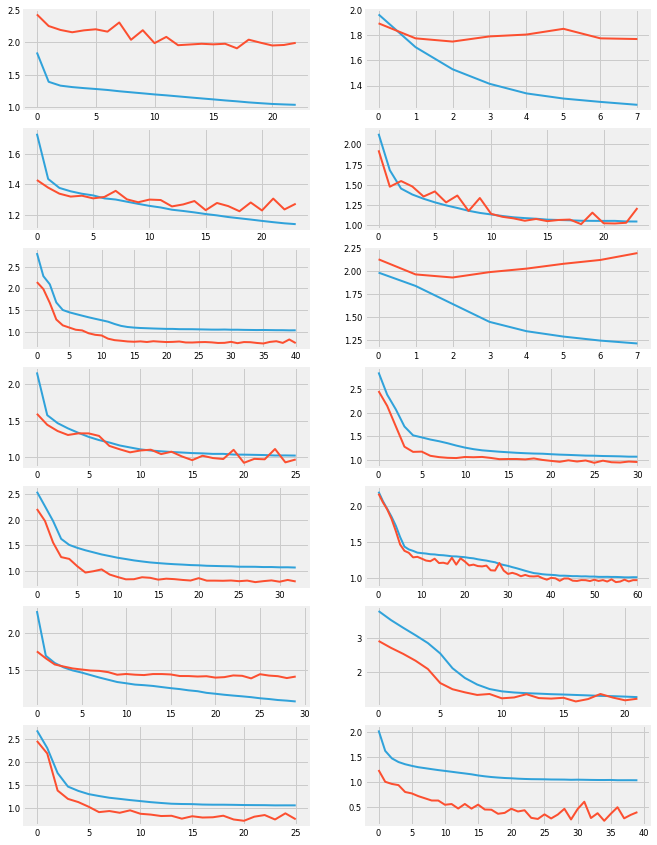

In [79]:
cv_metadata = u.cv_train_loso(
    gen_model, train_model,
    X[train_indices], y[train_indices], yi[train_indices]
)
u.cv_plot(cv_metadata)
cv_report = u.cv_report(cv_metadata)
cv_report

### Final model training

1.0509349500912355

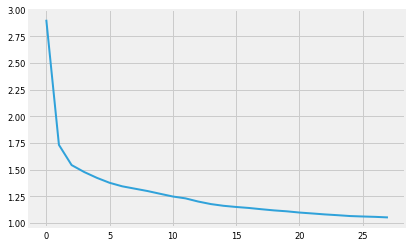

In [80]:
model = gen_model()
final_epochs = int(cv_report["epochs"][-1])
final_history = train_model(model, (X[train_indices], y[train_indices]), None, epochs=final_epochs)
final_loss = final_history.history["loss"][-1]
plt.plot(final_history.history["loss"])
final_loss

### Evaluation

In [81]:
regions = ["nat", *[f"hhs{i}" for i in range(1, 11)], None]

mdls = [*[cmp.name for cmp in components], "n-ensemble",
        "ave-ensemble", "prod-ensemble"]

eval_df = {mdl: [] for mdl in mdls}

for region in regions:
    if region is None:
        eval_indices = ~train_indices
    else:
        eval_indices = (~train_indices) & (yi[:, 1] == region)
        
    component_dists = [cmp.data[eval_indices] for cmp in components]
    n_dist = u.mdn_params_to_dists(model.predict(X[eval_indices]))
    
    dists = [
        *component_dists,
        n_dist,
        u.mean_ensemble(component_dists),
        u.prod_ensemble(component_dists)
    ]
    y_one_hot = u.wili_to_dists(y[eval_indices])
    
    for name, output in zip(mdls, dists):
        eval_df[name].append(losses.mean_cat_cross(y_one_hot, output))
eval_df = pd.DataFrame(eval_df)
eval_df.index = [*regions[:-1], "all"]
eval_df = eval_df[mdls]

# Save results
output_dir = u.ensure_dir(f"../results/{EXP_NAME}")
u.save_exp_summary(model, cv_report, {
    "loss": final_loss,
    "epochs": final_epochs
    
}, f"{output_dir}/{WEEK_NUMBER}_summary.txt")
eval_df.to_csv(f"{output_dir}/{WEEK_NUMBER}_eval.csv")
eval_df

,kcde,kde,sarima,n-ensemble,ave-ensemble,prod-ensemble
nat,3.08101167532393,3.301917641095085,3.0761441240741063,3.203582139332482,3.061058671674785,3.2499119429300958
hhs1,2.8901355250867486,3.3940255883787236,2.9940420509663483,3.191178785946937,3.0258224067145263,3.1570219388655802
hhs2,3.4714217372921197,3.7040516626956244,3.4648228273802744,3.50303447923737,3.5210318362938557,3.564303540722874
hhs3,3.162992469008748,3.466392863823155,3.488094549056908,3.333151103590309,3.308175599882158,3.1438811798452826
hhs4,3.2235918556230874,3.457281339559161,3.172269247198583,3.2808199838888203,3.1874893322272997,3.426378875479388
hhs5,3.356176143045347,3.4178280591820207,3.2368909524042264,3.239146894213872,3.2517875813524255,3.48138109741421
hhs6,3.931228721827084,4.45752385842302,4.052929409627834,4.2165542675449865,4.099627545575063,4.28561153723052
hhs7,3.2654147452216242,3.4490268654495386,3.3305817789562773,3.2844018554549748,3.301142734373359,3.5239036069111918
hhs8,3.0599284199373877,3.462250488312379,3.21852328685878,3.3147204719540717,3.2146487350821102,3.4448539481760725
hhs9,3.393733280969364,3.698493661950557,3.5406773970869208,3.468263260152834,3.51318993025822,3.149712438298065


## Plot random predictions

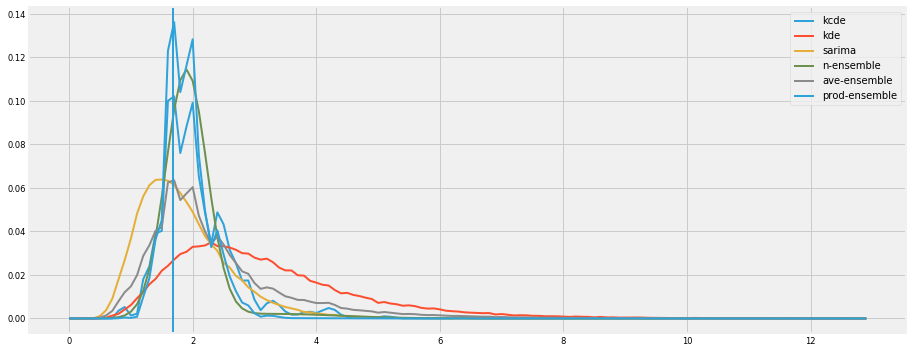

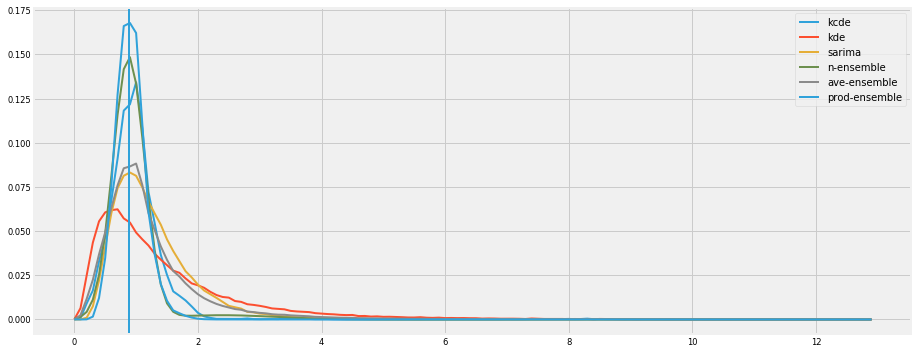

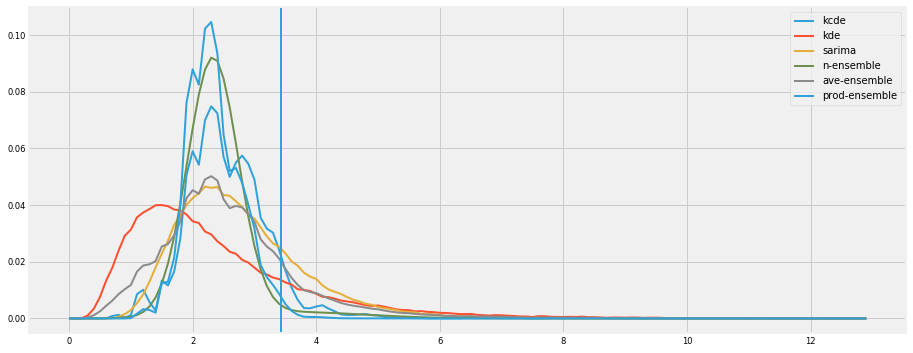

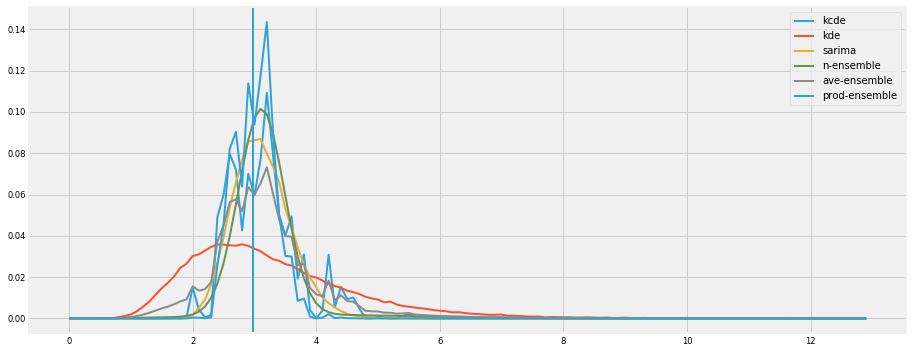

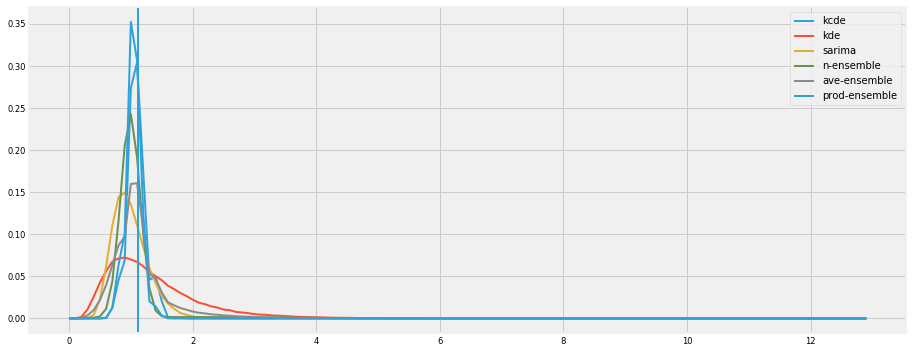

In [15]:
# Sample few of the examples
n_plots = 5
plot_indices = np.random.randint(0, y[~train_indices].shape[0], size=n_plots)

y_plot_out = y[~train_indices][plot_indices]

component_dists = [cmp.data[~train_indices][plot_indices] for cmp in components]
n_dist = u.mdn_params_to_dists(model.predict(X[~train_indices][plot_indices]))

dists = [
    *component_dists,
    n_dist,
    u.mean_ensemble(component_dists),
    u.prod_ensemble(component_dists)
]

bins = np.linspace(0, 12.9, 130)
mdls = [*[cmp.name for cmp in components], "n-ensemble", "ave-ensemble", "prod-ensemble"]

for pidx in range(n_plots):
    plt.figure(figsize=(14, 6))
    for idx, mdl in enumerate(mdls):
        plt.plot(bins, dists[idx][pidx], label=mdl)
    
    # Plot actual line
    plt.axvline(x=y_plot_out[pidx])
    
    plt.legend()